In [4]:
import os
import boto3
import io
import sagemaker

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.style.use("ggplot")
import pickle, gzip, urllib, json
import csv


In [5]:

from sagemaker import get_execution_role

role = get_execution_role()


In [6]:
role

'arn:aws:iam::674874789641:role/mod-6297809195fe4845-SageMakerExecutionRole-1HB3CH43GLIHV'

In [7]:
s3_client = boto3.client("s3")
data_bucket_name = "aws-ml-blog-sagemaker-census-segmentation"

In [8]:


obj_list = s3_client.list_objects(Bucket=data_bucket_name)
file = []
for contents in obj_list["Contents"]:
    file.append(contents["Key"])
print(file)



['Census_Data_for_SageMaker.csv']


In [9]:
file_data = file[0]

In [10]:
response = s3_client.get_object(Bucket=data_bucket_name, Key=file_data)
response_body = response["Body"].read()
counties = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)


In [11]:


counties.head()



,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [12]:


counties.dropna(inplace=True)
counties.shape



(3218, 37)

In [13]:


counties.index = counties["State"] + "-" + counties["County"]
counties.head()
drop = ["CensusId", "State", "County"]
counties.drop(drop, axis=1, inplace=True)
counties.head()



,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


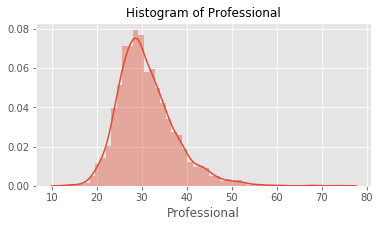

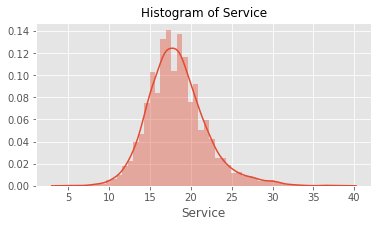

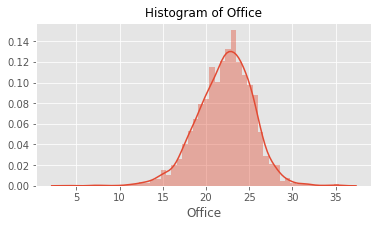

In [14]:


for a in ["Professional", "Service", "Office"]:
    ax = plt.subplots(figsize=(6, 3))
    ax = sns.distplot(counties[a])
    title = "Histogram of " + a
    ax.set_title(title, fontsize=12)
    plt.show()



In [15]:


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
counties_scaled = pd.DataFrame(scaler.fit_transform(counties))
counties_scaled.columns = counties.columns
counties_scaled.index = counties.index



In [16]:
counties_scaled.describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,...,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.009883,0.009866,0.009899,0.110170,0.756024,0.100942,0.018682,0.029405,0.006470,0.011540,...,0.046496,0.041154,0.124428,0.470140,0.009806,0.760810,0.194426,0.216744,0.029417,0.221775
std,0.031818,0.031692,0.031948,0.192617,0.229682,0.166262,0.078748,0.062744,0.035446,0.033933,...,0.051956,0.042321,0.085301,0.143135,0.032305,0.132949,0.106923,0.106947,0.046451,0.112138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001092,0.001117,0.001069,0.019019,0.642285,0.005821,0.001086,0.004808,0.000000,0.001371,...,0.019663,0.023018,0.072581,0.373402,0.000948,0.697279,0.120861,0.147541,0.010204,0.150685
50%,0.002571,0.002591,0.002539,0.039039,0.842685,0.022119,0.003257,0.012019,0.000000,0.003219,...,0.033708,0.033248,0.104839,0.462916,0.002234,0.785714,0.172185,0.188525,0.020408,0.208219
75%,0.006594,0.006645,0.006556,0.098098,0.933868,0.111758,0.006515,0.028846,0.000000,0.008237,...,0.056180,0.048593,0.150538,0.560102,0.006144,0.853741,0.243377,0.256831,0.030612,0.271233
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
sess = sagemaker.Session()
bucket = sess.default_bucket()

In [18]:
from sagemaker import PCA

num_components = 33

pca_SM = PCA(
    role=role,
    train_instance_count=1,
    train_instance_type="ml.c4.xlarge",
    output_path="s3://" + bucket + "/counties/",
    num_components=num_components,
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [19]:
train_data = counties_scaled.values.astype("float32")

In [20]:


%%time
pca_SM.fit(pca_SM.record_set(train_data))



Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-05-27 23:46:22 Starting - Starting the training job...
2021-05-27 23:46:45 Starting - Launching requested ML instancesProfilerReport-1622159182: InProgress
......
2021-05-27 23:47:46 Starting - Preparing the instances for training.........
2021-05-27 23:49:19 Downloading - Downloading input data
2021-05-27 23:49:19 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/27/2021 23:49:23 INFO 139773966387008] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[05/27/2021 23:49:23 INFO 139773966387008] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim': 

In [21]:


job_name = pca_SM.latest_training_job.name
model_key = "counties/" + job_name + "/output/model.tar.gz"

boto3.resource("s3").Bucket(bucket).download_file(model_key, "model.tar.gz")
os.system("tar -zxvf model.tar.gz")



0

In [23]:


!pip install mxnet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 46.9 MB 133 kB/s  eta 0:00:01     |███████████████████████████████ | 45.3 MB 14.2 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [24]:

import mxnet as mx

In [25]:
pca_model_params = mx.ndarray.load("model_algo-1")

In [26]:
s = pd.DataFrame(pca_model_params["s"].asnumpy())
v = pd.DataFrame(pca_model_params["v"].asnumpy())

In [27]:
s.iloc[28:, :].apply(lambda x: x * x).sum() / s.apply(lambda x: x * x).sum()

0    0.717983
dtype: float32

In [28]:
s_5 = s.iloc[28:, :]
v_5 = v.iloc[:, 28:]
v_5.columns = [0, 1, 2, 3, 4]


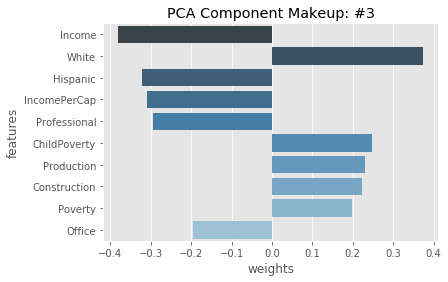

In [31]:
component_num = 3

first_comp = v_5[5 - component_num]
comps = pd.DataFrame(
    list(zip(first_comp, counties_scaled.columns)), columns=["weights", "features"]
)
comps["abs_weights"] = comps["weights"].apply(lambda x: np.abs(x))
ax = sns.barplot(
    data=comps.sort_values("abs_weights", ascending=False).head(10),
    x="weights",
    y="features",
    palette="Blues_d",
)
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

In [32]:


PCA_list = ["comp_1", "comp_2", "comp_3", "comp_4", "comp_5"]

In [34]:
pca_predictor = pca_SM.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------!

In [35]:
%%time
result = pca_predictor.predict(train_data)

CPU times: user 179 ms, sys: 14.5 ms, total: 194 ms
Wall time: 576 ms


In [36]:
counties_transformed = pd.DataFrame()
for a in result:
    b = a.label["projection"].float32_tensor.values
    counties_transformed = counties_transformed.append([list(b)])
counties_transformed.index = counties_scaled.index
counties_transformed = counties_transformed.iloc[:, 28:]
counties_transformed.columns = PCA_list


In [37]:
counties_transformed.head()

,comp_1,comp_2,comp_3,comp_4,comp_5
Alabama-Autauga,-0.010824,0.120480,-0.088356,0.160527,-0.060274
Alabama-Baldwin,-0.068677,-0.023092,-0.145743,0.185969,-0.149684
Alabama-Barbour,0.093111,0.297829,0.146258,0.296662,0.506202
Alabama-Bibb,0.283526,0.011757,0.224402,0.190861,0.069224
Alabama-Blount,0.100738,-0.193824,0.022714,0.254403,-0.091030


In [38]:
train_data = counties_transformed.values.astype("float32")

In [39]:
from sagemaker import KMeans

num_clusters = 7
kmeans = KMeans(
    role=role,
    train_instance_count=1,
    train_instance_type="ml.c4.xlarge",
    output_path="s3://" + bucket + "/counties/",
    k=num_clusters,
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [40]:


%%time
kmeans.fit(kmeans.record_set(train_data))



Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-05-28 02:26:54 Starting - Starting the training job...
2021-05-28 02:27:17 Starting - Launching requested ML instancesProfilerReport-1622168814: InProgress
......
2021-05-28 02:28:17 Starting - Preparing the instances for training.........
2021-05-28 02:29:51 Downloading - Downloading input data
2021-05-28 02:29:51 Training - Downloading the training image...
2021-05-28 02:30:19 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[05/28/2021 02:30:16 INFO 140528566150976] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '

In [41]:

%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type="ml.t2.medium")


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------------!CPU times: user 324 ms, sys: 28.5 ms, total: 352 ms
Wall time: 10min 32s


In [43]:
%%time
result = kmeans_predictor.predict(train_data)

CPU times: user 200 ms, sys: 3.71 ms, total: 204 ms
Wall time: 585 ms


In [44]:
cluster_labels = [r.label["closest_cluster"].float32_tensor.values[0] for r in result]

In [45]:
pd.DataFrame(cluster_labels)[0].value_counts()

1.0    984
2.0    729
5.0    454
4.0    407
6.0    335
0.0    214
3.0     95
Name: 0, dtype: int64

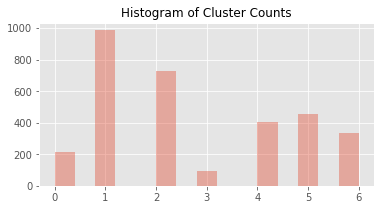

In [46]:


ax = plt.subplots(figsize=(6, 3))
ax = sns.distplot(cluster_labels, kde=False)
title = "Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()



#Accessing KMeans Model Attributes

In [47]:
job_name = kmeans.latest_training_job.name
model_key = "counties/" + job_name + "/output/model.tar.gz"

boto3.resource("s3").Bucket(bucket).download_file(model_key, "model.tar.gz")
os.system("tar -zxvf model.tar.gz")

0

In [48]:
Kmeans_model_params = mx.ndarray.load("model_algo-1")

In [49]:
cluster_centroids = pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns = counties_transformed.columns

In [50]:

cluster_centroids


,comp_1,comp_2,comp_3,comp_4,comp_5
0,0.116162,-0.105750,-0.060156,-0.323632,0.425750
1,-0.030528,-0.076485,0.016322,0.071886,-0.215306
2,-0.024481,-0.035187,0.136088,0.093071,0.043943
3,-0.104098,-0.413681,-0.190455,-0.236516,1.246433
4,-0.013091,0.061755,-0.346969,0.046680,-0.093458
5,0.023910,0.073401,0.100018,-0.337746,-0.187033
6,0.112063,0.308928,0.059172,0.250307,0.394570


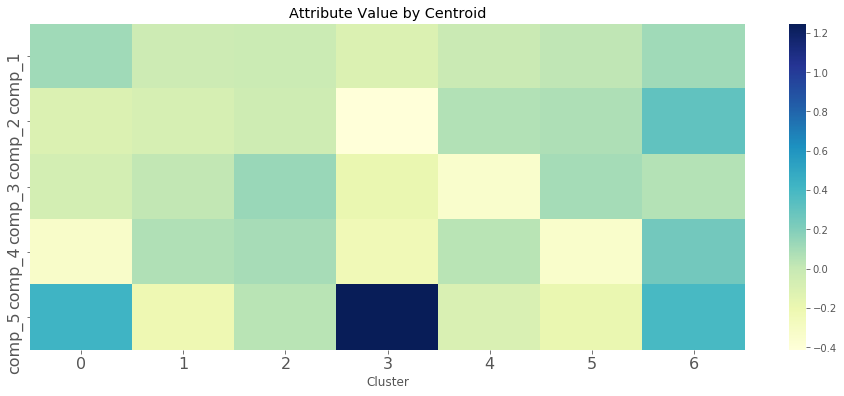

In [51]:
plt.figure(figsize=(16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap="YlGnBu")
ax.set_xlabel("Cluster")
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [52]:
counties_transformed["labels"] = list(map(int, cluster_labels))
counties_transformed.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,labels
Alabama-Autauga,-0.010824,0.120480,-0.088356,0.160527,-0.060274,1
Alabama-Baldwin,-0.068677,-0.023092,-0.145743,0.185969,-0.149684,1
Alabama-Barbour,0.093111,0.297829,0.146258,0.296662,0.506202,6
Alabama-Bibb,0.283526,0.011757,0.224402,0.190861,0.069224,2
Alabama-Blount,0.100738,-0.193824,0.022714,0.254403,-0.091030,1


In [53]:
cluster = counties_transformed[counties_transformed["labels"] == 1]
cluster.head(5)

,comp_1,comp_2,comp_3,comp_4,comp_5,labels
Alabama-Autauga,-0.010824,0.120480,-0.088356,0.160527,-0.060274,1
Alabama-Baldwin,-0.068677,-0.023092,-0.145743,0.185969,-0.149684,1
Alabama-Blount,0.100738,-0.193824,0.022714,0.254403,-0.091030,1
Alabama-Cullman,-0.027857,-0.169405,0.087640,0.195683,-0.136151,1
Alabama-Limestone,0.033746,0.014973,-0.089967,0.151180,-0.089334,1



Conclusion

You have just walked through a data science workflow for unsupervised learning, specifically clustering a dataset using KMeans after reducing the dimensionality using PCA. By accessing the underlying models created within Amazon SageMaker, we were able to improve the explainability of our modelling and draw actionable conclusions. Using these techniques, we have been able to better understand the essential characteristics of different counties in the US and segment the electorate into groupings accordingly.


Because endpoints are persistent, let’s delete our endpoints now that we’re done to avoid any excess charges on our AWS bill.

In [54]:
sagemaker.Session().delete_endpoint(pca_predictor.endpoint)
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
